In [176]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress, entropy

from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from boruta import BorutaPy

import matplotlib.pyplot as plt


In [152]:
df

,date,Income,Outcome,Balance,Saldo,avg_temp_msk,banks_funds_on_cbr_corr_accounts_in_russia,banks_funds_on_cbr_corr_accounts_in_moscow_region,key_rate,lower_bound_deposit_rate,...,usd_avg_rate_tomorrow,usd_volume_tomorrow,eur_avg_rate_today,eur_volume_today,eur_avg_rate_tomorrow,eur_volume_tomorrow,tax_payments,declaration_day,avance_day,eco_payments_day
0,2017-01-09,1.343028,1.487865,-0.155904,-0.144836,-6.946667,2041.3,1704.7,10.0,9.0,...,59.8675,2611.805,63.0176,176.525,63.0278,263.770,1.0,0.0,0.0,0.0
1,2017-01-10,1.068610,1.194182,-0.125572,-0.125572,-6.840000,1567.9,1350.4,10.0,9.0,...,60.0041,3231.872,63.5227,239.949,63.5212,239.392,0.0,0.0,0.0,0.0
2,2017-01-11,0.944429,0.936663,0.007767,0.007767,-6.733333,1526.8,1313.3,10.0,9.0,...,60.2149,3663.963,63.3733,156.503,63.3437,309.014,0.0,0.0,0.0,0.0
3,2017-01-12,1.672202,0.875379,0.800391,0.796823,-6.626667,2472.7,2280.6,10.0,9.0,...,59.3485,3669.495,63.1847,198.967,63.1705,306.948,0.0,0.0,0.0,0.0
4,2017-01-13,0.955924,0.975645,-0.019721,-0.019721,-6.520000,2440.5,2219.0,10.0,9.0,...,59.4748,2512.063,63.1565,165.232,63.2411,232.421,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,2021-03-27,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1539,2021-03-28,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1540,2021-03-29,2.356883,3.370738,-1.017679,-1.013855,6.913333,2565.7,2401.8,4.5,3.5,...,75.8845,2293.707,89.3914,118.831,89.3448,289.155,1.0,1.0,0.0,0.0
1541,2021-03-30,2.317382,2.567554,-0.259687,-0.250172,7.206667,2426.4,2296.4,4.5,3.5,...,75.8712,3024.296,88.9712,272.726,89.0471,299.402,0.0,1.0,0.0,0.0


In [156]:
df = pd.read_excel('ts_data_new_filled_v2.xlsx')
df = df.drop('Balance', axis = 1)

In [100]:
"""
Модуль для автоматизированного отбора признаков.
Реализует три категории методов:
 1) Filter: Mutual Information + mRMR
 2) Wrapper: Boruta (RandomForest)
 3) Embedded: Lasso / ElasticNet

А также последовательный pipeline: filter → wrapper → embedded.
"""

def filter_selection_mrmr(df: pd.DataFrame,
                          feature_cols: list[str],
                          target_col: str,
                          k: int = 10,
                          random_state: int = 42) -> list[str]:
    """
    Filter: mRMR отбор признаков.
    1) Вычисляем MI(f; y)
    2) Жадно добавляем по критерию: MI(f; y) - avg_s MI(f; s)
    """
    df_clean = df.dropna(subset=feature_cols + [target_col])
    X = df_clean[feature_cols]
    y = df_clean[target_col].values

    # mutual information с таргетом
    mi_target = dict(zip(
        feature_cols,
        mutual_info_regression(X.values, y, random_state=random_state)
    ))

    selected = []
    candidates = set(feature_cols)

    while len(selected) < k and candidates:
        scores = {}
        for f in tqdm(candidates):
            red = 0.0
            if selected:
                # средняя MI с уже выбранными
                mis = []
                for s in selected:
                    mi_fs = mutual_info_regression(
                        df_clean[[f]].values,
                        df_clean[s].values,
                        random_state=random_state
                    )[0]
                    mis.append(mi_fs)
                red = np.mean(mis)
            scores[f] = mi_target[f] - red
        best = max(scores, key=scores.get)
        selected.append(best)
        candidates.remove(best)
    return selected


def boruta_selection(df: pd.DataFrame,
                      feature_cols: list[str],
                      target_col: str,
                      n_estimators: int = 100,
                      random_state: int = 42) -> list[str]:
    """
    Wrapper: BorutaPy на основе RandomForestRegressor.
    Возвращает список фич, поддержанных Boruta.
    """
    df_clean = df.dropna(subset=feature_cols + [target_col])
    X = df_clean[feature_cols].values
    y = df_clean[target_col].values

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    boruta = BorutaPy(estimator=rf,
                      n_estimators='auto',
                      random_state=random_state)
    boruta.fit(X, y)

    selected = [f for f, keep in zip(feature_cols, boruta.support_) if keep]
    return selected


def embedded_selection(df: pd.DataFrame,
                       feature_cols: list[str],
                       target_col: str,
                       method: str = 'lasso',
                       cv: int = 5,
                       random_state: int = 42) -> list[str]:
    """
    Embedded: LassoCV или ElasticNetCV.
    Возвращает фичи с ненулевыми коэффициентами.
    """
    df_clean = df.dropna(subset=feature_cols + [target_col])
    X = df_clean[feature_cols].values
    y = df_clean[target_col].values

    if method == 'elasticnet':
        model = ElasticNetCV(cv=cv, random_state=random_state).fit(X, y)
    else:
        model = LassoCV(cv=cv, random_state=random_state).fit(X, y)

    coefs = model.coef_
    selected = [f for f, c in zip(feature_cols, coefs) if abs(c) > 1e-6]
    return selected


def sequential_feature_selection(
    df: pd.DataFrame,
    feature_cols: list[str],
    target_col: str,
    k_filter: int = 30,
    boruta_n_estimators: int = 100,
    embedded_method: str = 'lasso',
    cv: int = 5,
    random_state: int = 42
) -> dict:
    """
    Запускает отбор признаков последовательно:
      1) Filter (mRMR) → top k_filter
      2) Wrapper (Boruta) → subset
      3) Embedded (Lasso/ElasticNet) → финальный набор

    Возвращает словарь:
      {
        'filter': [...],
        'wrapper': [...],
        'embedded': [...],
        'final': [...]  # совпадает с 'embedded'
      }
    """
    # 1. Filter
    filt = filter_selection_mrmr(
        df, feature_cols, target_col,
        k=k_filter, random_state=random_state
    )
    # 2. Wrapper на отфильтрованных
    wrap = boruta_selection(
        df, filt, target_col,
        n_estimators=boruta_n_estimators,
        random_state=random_state
    )
    # 3. Embedded на оставшихся
    emb = embedded_selection(
        df, wrap, target_col,
        method=embedded_method,
        cv=cv,
        random_state=random_state
    )
    return {
        'filter': filt,
        'wrapper': wrap,
        'embedded': emb,
        'final': emb
    }

In [89]:
def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["dow"] = df.index.dayofweek
    df["month"] = df.index.month
    df["is_month_end"] = df.index.is_month_end.astype(int)
    df["is_quarter_end"] = df.index.is_quarter_end.astype(int)
    return df

def add_lag_features(df: pd.DataFrame, cols: list[str], n_lags: int = 30) -> pd.DataFrame:
    """
    Для каждого столбца в cols генерирует n_lags лагов: col_lag1 ... col_lag{n_lags}.
    """
    df = df.copy()
    for col in cols:
        for lag in range(1, n_lags + 1):
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df


def add_rolling_features(df: pd.DataFrame,
                         cols: list[str],
                         windows: list[int] = [7, 30],
                         stats: list[str] = ['mean', 'std']) -> pd.DataFrame:
    """
    Добавляет для каждого col и каждого окна w в windows:
      - скользящее среднее:    col_roll_mean_{w}
      - скользящее std отклон: col_roll_std_{w}
    Все скользящие рассчитываются с задержкой 1 периода.
    """
    df = df.copy()
    for col in cols:
        for w in windows:
            roll = df[col].shift(1).rolling(window=w, min_periods=1)
            if 'mean' in stats:
                df[f"{col}_roll_mean_{w}"] = roll.mean()
            if 'std' in stats:
                df[f"{col}_roll_std_{w}"]  = roll.std()
    return df


def add_diff_features(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Добавляет первые разности для каждого col: col_diff1 = col - col.shift(1).
    Помогает убрать тренд.
    """
    df = df.copy()
    for col in cols:
        df[f"{col}_diff1"] = df[col].diff(1)
    return df


def generate_features(df: pd.DataFrame,
                            target_col: str = 'Saldo',
                            lag_target: int = 30,
                            lag_macro: int = 3,
                            roll_windows: list[int] = [7, 30]) -> pd.DataFrame:
    """
    Собирает итоговую матрицу признаков:
    1. Календарные признаки
    2. Лаги по target_col
    3. Лаги для макрофакторов (lag_macro)
    4. Скользящие статистики по target_col
    5. Первые разности по target_col
    6. Существующие tax_*, macro, usd/eur поля и флаги сохраняются

    Возвращает DataFrame, готовый к обучению (с удалёнными NaN).
    """
    df_feat = df.copy()

    # 1. Calendar
    df_feat = add_calendar_features(df_feat)

    # 2. Lags of target
    df_feat = add_lag_features(df_feat, cols=[target_col], n_lags=lag_target)

    # 3. Macro factors lags
    macro_cols = ['key_rate',
       'lower_bound_deposit_rate', 'upper_bound_repo_loans_rate',
       'upper_bound_overnight_loans_rate', 'miacr', 'ruonia',
       'gov_bonds_yield_curve_0_25y', 'gov_bonds_yield_curve_0_5y',
       'gov_bonds_yield_curve_0_75y', 'gov_bonds_yield_curve_1y',
       'gov_bonds_yield_curve_2y', 'gov_bonds_yield_curve_3y',
       'gov_bonds_yield_curve_5y', 'gov_bonds_yield_curve_7y',
       'gov_bonds_yield_curve_10y', 'gov_bonds_yield_curve_15y',
       'gov_bonds_yield_curve_20y', 'gov_bonds_yield_curve_30y',
       'standing_liquidity_rate_additional', 'max_deposit_auction_bid_rate',
       'min_repo_auction_bid_rate_main_fine_tuning',
       'min_repo_auction_bid_rate_1m', 'min_repo_auction_bid_rate_1y',
       'min_credit_auction_bid_rate_non_market', 'standing_liquidity_rate_1d',
       'standing_liquidity_rate_margin_2_90d',
       'standing_liquidity_rate_non_market_90d_plus', 'min_repo_rates_1d',
       'min_repo_rates_7d', 'min_repo_rates_1m', 'min_repo_rates_3m',
       'min_repo_rates_6m', 'min_repo_rates_12m', 'standing_deposit_rate',
       'max_deposit_auction_bid_rate.1', 'min_repo_auction_bid_rate_main_fine',
       'min_repo_auction_bid_rate_1m.1', 'min_repo_auction_bid_rate_1y.1',
       'standing_liquidity_rate_1d_ops',
       'standing_liquidity_rate_margin_2_90d.1',
       'standing_liquidity_rate_non_market_90d_plus.1',
       'non_oil_gas_gdp_volume_index', 'usd_avg_rate_today','usd_avg_rate_tomorrow', 'eur_avg_rate_tomorrow']
    
    df_feat = add_lag_features(df_feat, cols=macro_cols, n_lags=lag_macro)

    # 4. Rolling stats of target
    df_feat = add_rolling_features(df_feat, cols=[target_col], windows=roll_windows)

    # 5. First differences of target
    df_feat = add_diff_features(df_feat, cols=[target_col])

    # 6. Удаляем NaN-строки
    df_feat.dropna(inplace=True)
    return df_feat

In [77]:
class DriftDetector:
    def __init__(self, window_size=20, ewma_alpha=0.3, cusum_threshold=5):
        self.window_size = window_size
        self.ewma_alpha = ewma_alpha
        self.cusum_threshold = cusum_threshold
        self.ewma_prev = None
        self.cusum_pos = 0
        self.cusum_neg = 0

    def detect(self, series: pd.Series) -> bool:
        if len(series) < self.window_size:
            return False

        rolling_mean = series.rolling(window=self.window_size).mean()
        rolling_std = series.rolling(window=self.window_size).std()

        val = series.iloc[-1]
        mean = rolling_mean.iloc[-1]
        std = rolling_std.iloc[-1]

        # EWMA
        if self.ewma_prev is None:
            self.ewma_prev = val
        ewma = self.ewma_alpha * val + (1 - self.ewma_alpha) * self.ewma_prev
        self.ewma_prev = ewma

        ewma_deviation = abs(val - ewma)

        # CUSUM
        k = 0.5 * std
        self.cusum_pos = max(0, self.cusum_pos + val - mean - k)
        self.cusum_neg = min(0, self.cusum_neg + val - mean + k)

        cusum_alert = self.cusum_pos > self.cusum_threshold or abs(self.cusum_neg) > self.cusum_threshold

        # Логика триггера разладки
        if ewma_deviation > 2 * std or cusum_alert:
            print(f"Drift detected: EWMA deviation = {ewma_deviation}, CUSUM = {self.cusum_pos}/{self.cusum_neg}")
            return True

        return False

In [85]:
df

Index(['date', 'Income', 'Outcome', 'Balance', 'Saldo', 'avg_temp_msk',
       'banks_funds_on_cbr_corr_accounts_in_russia',
       'banks_funds_on_cbr_corr_accounts_in_moscow_region', 'key_rate',
       'lower_bound_deposit_rate', 'upper_bound_repo_loans_rate',
       'upper_bound_overnight_loans_rate', 'miacr', 'ruonia',
       'consumer_price_index_goods_services_monthly_pct',
       'tota_empoloyed_thousands', 'managers_thousands',
       'high_skill_specialists_thousands', 'mid_skill_specialists_thousands',
       'clerks_admin_services_thousands',
       'service_trade_security_workers_thousands',
       'skilled_agri_forest_fishery_workers_thousands',
       'skilled_industry_construction_transport_workers_thousands',
       'plant_machine_operators_drivers_thousands',
       'unskilled_workers_thousands', 'gdp_rub_abs_bn',
       'gov_bonds_yield_curve_0_25y', 'gov_bonds_yield_curve_0_5y',
       'gov_bonds_yield_curve_0_75y', 'gov_bonds_yield_curve_1y',
       'gov_bonds_yield

In [180]:
class ARIMAPipeline:
    """
    Пайплайн ARIMA с логикой, аналогичной ModelRunner:
    - итеративное разделение на train/valid/test
    - имитация увеличивающейся обучающей выборки или скользящего окна
    - заполнение пропусков
    - автоматический ре-трейн по расписанию и при дрейфе
    - логирование MAE и флага ре-трейна
    """
    def __init__(self,
                 dataframe: pd.DataFrame,
                 date_col: str = 'date',
                 target_col: str = 'Saldo',
                 train_sample_format: str = 'increasing',  # 'increasing' или 'sliding_window'
                 inplace_type: str = '-1e10',              # или 'mean'
                 test_days: int = 30,
                 min_train_days: int = 60,
                 retrain_freq: int = 30,
                 drift_threshold: float = 0.05):
        self.df = dataframe.copy()
        self.date_col = date_col
        self.target_col = target_col
        self.train_sample_format = train_sample_format
        self.inplace_type = inplace_type
        self.test_days = test_days
        self.min_train_days = min_train_days
        self.retrain_freq = retrain_freq
        self.drift_threshold = drift_threshold

        # Подготовка датафрейма
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])
        self.df.sort_values(self.date_col, inplace=True)
        self.df.set_index(self.date_col, inplace=True)
        self.df = self.df.asfreq('D').fillna(method='ffill')

        self.scaler = StandardScaler()
        self.selected_features = None
        self.model = None
        self.last_retrain_idx = None

        self.df_results = pd.DataFrame(columns=[
            'Date', 'train_period', 'test_period', 'MAE', 'Retrained'
        ])

    def run_loop(self) -> pd.DataFrame:
        prev_mae = None
          
        # итерации по точкам разбиения
        for idx in tqdm(range(self.min_train_days,
                               len(self.df) - self.test_days + 1)):
            # формируем train и test
            if self.train_sample_format == 'increasing':
                df_train = self.df.iloc[:idx]
            else:
                df_train = self.df.iloc[idx - self.min_train_days:idx]
            df_test = self.df.iloc[idx: idx + self.test_days]

            # train/valid split
            train_split, valid_split = train_test_split(
                df_train, test_size=0.2, shuffle=False)
            # разделяем X/y
            x_train = train_split.drop(columns=[self.target_col])
            y_train = train_split[self.target_col]
            x_valid = valid_split.drop(columns=[self.target_col])
            y_valid = valid_split[self.target_col]
            x_test  = df_test.drop(columns=[self.target_col])
            y_test  = df_test[self.target_col]

            # заполнение пропусков
            if self.inplace_type == '-1e10':
                fill_val = -1e10
                x_train.fillna(fill_val, inplace=True)
                x_valid.fillna(fill_val, inplace=True)
                x_test.fillna(fill_val, inplace=True)
            else:
                mean_vals = x_train.mean()
                x_train.fillna(mean_vals, inplace=True)
                x_valid.fillna(mean_vals, inplace=True)
                x_test.fillna(mean_vals, inplace=True)

            train_period = f"{y_train.index.min().date()}/{y_train.index.max().date()}"
            test_period  = f"{y_test.index.min().date()}/{y_test.index.max().date()}"

            # определяем необходимость ре-трейна
            retrained = False
            if (self.model is None or
                (self.last_retrain_idx is not None and idx - self.last_retrain_idx >= self.retrain_freq)):
                retrained = True
                self._train_model(pd.concat([x_train, x_valid]),
                                   pd.concat([y_train, y_valid]))
                self.last_retrain_idx = idx

            # прогноз
            x_test_feat = x_test[self.selected_features]
            X_test_scaled = self.scaler.transform(x_test_feat)
            y_pred = self.model.predict(n_periods=len(X_test_scaled), X=X_test_scaled)

            mae = mean_absolute_error(y_test, y_pred)

            # проверка дрейфа
            if prev_mae is not None and mae - prev_mae > self.drift_threshold:
                retrained = True
                self._train_model(pd.concat([x_train, x_valid]),
                                   pd.concat([y_train, y_valid]))
                X_test_scaled = self.scaler.transform(
                    x_test[self.selected_features]
                )
                y_pred = self.model.predict(n_periods=len(X_test_scaled), X=X_test_scaled)
                mae = mean_absolute_error(y_test, y_pred)
                self.last_retrain_idx = idx

            # логирование результатов
            self.df_results.loc[len(self.df_results)] = [
                y_test.index[-1].date(),
                train_period,
                test_period,
                mae,
                retrained
            ]
            prev_mae = mae

        return self.df_results

    def _train_model(self, X: pd.DataFrame, y: pd.Series):
        # фичер-селекшн
        self.selected_features = X.columns.tolist()  # или вызвать feature selection
        # масштабирование
        X_scaled = self.scaler.fit_transform(X[self.selected_features])
        # обучение auto_arima
        self.model = auto_arima(
            y=y,
            exogenous=X_scaled,
            seasonal=True,
            m=7,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

In [182]:
arima_pipeline = ARIMAPipeline(df)

In [184]:
results = arima_pipeline.run_loop()

100%|██████████| 1454/1454 [13:29<00:00,  1.80it/s]


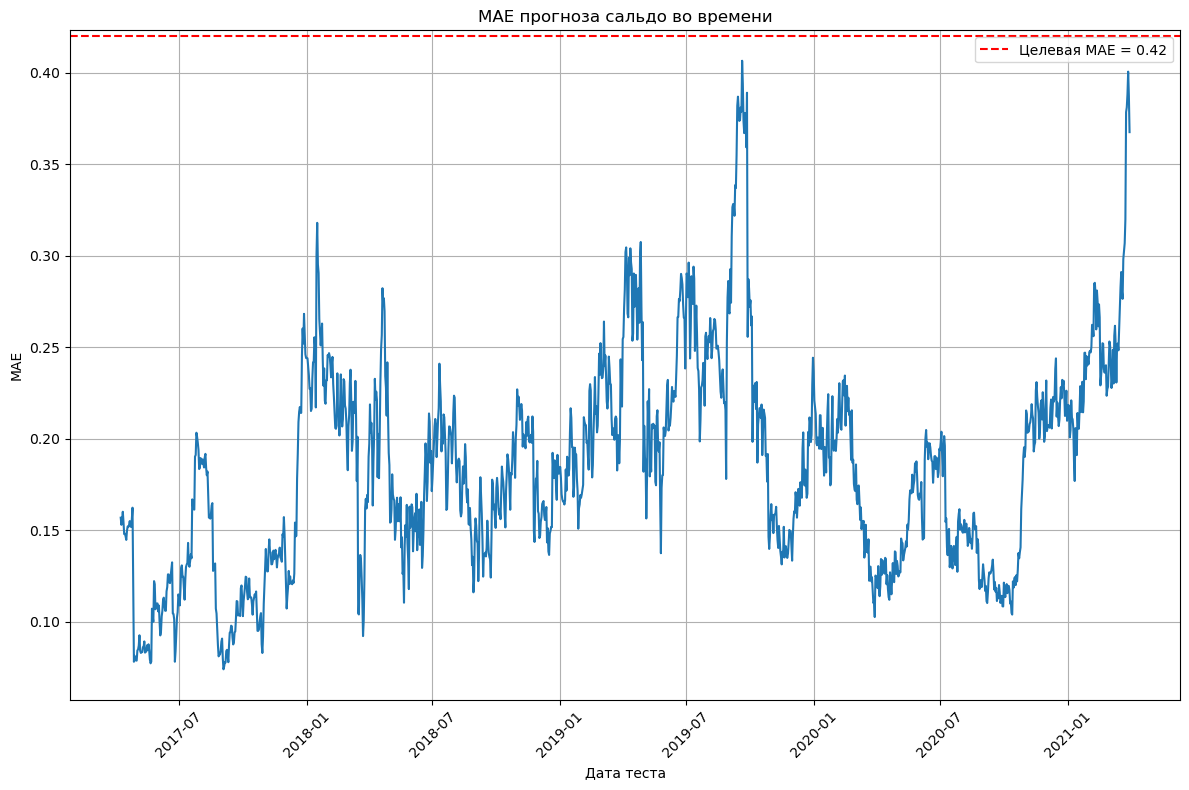

In [200]:
df_res = results.copy()

# Если Date хранится не в datetime
df_res['Date'] = pd.to_datetime(df_res['Date'])

# Построение
plt.figure(figsize=(12, 8))
plt.plot(df_res['Date'], df_res['MAE'], linestyle='-')
plt.axhline(y=0.42, color='red', linestyle='--', label='Целевая MAE = 0.42')
plt.title('MAE прогноза сальдо во времени')
plt.xlabel('Дата теста')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

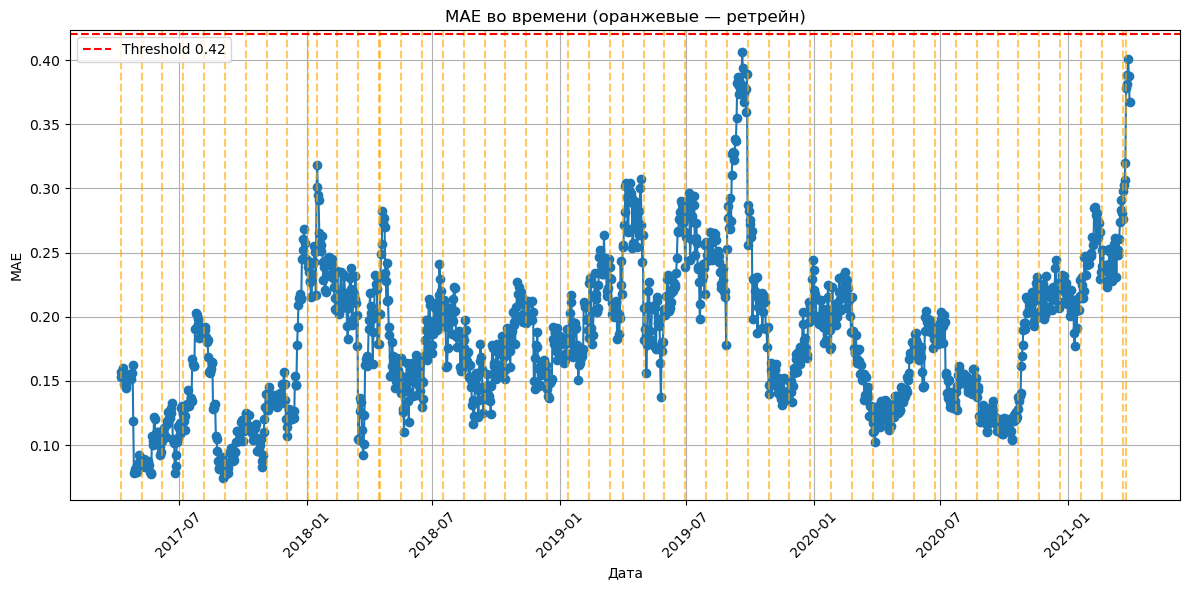

In [198]:
# Отметить ретрейн-периоды
retrain_dates = df_res.loc[df_res['Retrained'], 'Date']

plt.figure(figsize=(12, 6))
plt.plot(df_res['Date'], df_res['MAE'], marker='o', linestyle='-')
for d in retrain_dates:
    plt.axvline(d, color='orange', linestyle='--', alpha=0.6)
plt.axhline(y=0.42, color='red', linestyle='--', label='Threshold 0.42')
plt.title('MAE во времени (оранжевые — ретрейн)')
plt.xlabel('Дата')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()